In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import os
import dask.dataframe as dd

pd.set_option('display.max_rows', 100)

DATA_PATH = '..\\data\\'

In [8]:
def load_data(path, sep=','):
    path = os.path.join(DATA_PATH, path)
    return pd.read_csv(path, sep=sep)

In [9]:
books = load_data('gr_books.csv')

In [10]:
books.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780440e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9.780440e+12,eng,870,2153167,29221,9/01/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9.780440e+12,eng,352,6333,244,11/01/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.780440e+12,eng,435,2339585,36325,5/01/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9.780440e+12,eng,2690,41428,164,9/13/2004,Scholastic


count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64


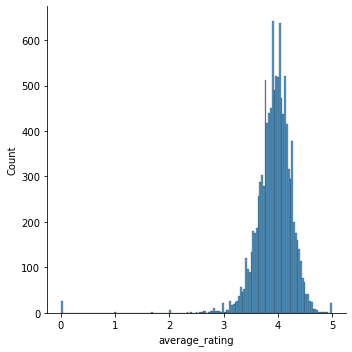

In [11]:
print(books.average_rating.describe())

sns.displot(books.average_rating)

# NOTE: maybe remove books with 0 average rating and fewer than a certain number of ratings

count    1.112700e+04
mean     1.793641e+04
std      1.124794e+05
min      0.000000e+00
25%      1.040000e+02
50%      7.450000e+02
75%      4.993500e+03
max      4.597666e+06
Name: ratings_count, dtype: float64
2725 books have fewer than 100 ratings
Compared to 11127 books


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


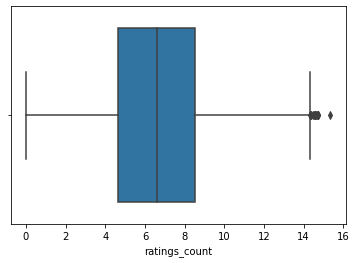

In [12]:
print(books.ratings_count.describe())

sns.boxplot(np.log1p(books.ratings_count))

# NOTE: maybe remove books with fewer than a certain number of ratings

print("{} books have fewer than 100 ratings".format(books[books.ratings_count < 100].shape[0]))
print("Compared to {} books".format(books.shape[0]))

In [13]:
books.head(1)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780440e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.


Comment for each column:

1. bookID: useless
2. title: very useful, tf-idf or some other embedding could be very useful
3. authors: again could be very useful. Might list out authors as a list rather than this unstructured string
4. average_rating: could be a good numerical feature
5. idbn: useless
6. isbn13: useless
7. language_code: maybe could limit suggestions to this, or could one-hot encode to use as a feature
8. num_pages: could be useful again.
9. ratings_count: perhaps could build up a new `confidence` score based on rating and ratings_count using bayesian statistics
10. text_reviews_count: again same as above, useful feature could be ratio of ratings to text reviews, but hard to tell the sentiment of those reviews without further knowledge
11. publication_date: unsure how useful this would be
12. publisher: could be good to one-hot encode.

I know that most recommendations models are based on both users and content, but here we only have content data.

In [14]:
books.publisher.value_counts()
# 2292 unique publishers

Vintage                        318
Penguin Books                  261
Penguin Classics               184
Mariner Books                  150
Ballantine Books               144
                              ... 
University of Calgary Press      1
Marlowe & Company                1
University Press of America      1
Abstract Studio                  1
Sounds True                      1
Name: publisher, Length: 2292, dtype: int64

In [15]:
x = books.language_code.value_counts()
print(x)
len(x) # 27 values, could be good to one-hot encode, could merge eng, en-US, en-GB and en-CA

eng      8911
en-US    1409
spa       218
en-GB     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-CA       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: language_code, dtype: int64


27

I think at this stage any recommender system based solely on the content wouldn't be that interesting, it would amount to just finding the cosine or euclidean distance of the new vector and every other training instance.

Time to search for a user AND content dataset. Thank you [Kaggle](https://www.kaggle.com/datasets/somnambwl/bookcrossing-dataset?select=Books.csv).

In [16]:
bc_books = load_data('bc_books.csv', sep=';')

In [17]:
for c in bc_books.columns:
    print(c)
    print(bc_books[c].describe())
    print()

ISBN
count         271379
unique        271378
top       0486404242
freq               2
Name: ISBN, dtype: object

Title
count             271379
unique            242154
top       Selected Poems
freq                  27
Name: Title, dtype: object

Author
count              271378
unique             102030
top       Agatha Christie
freq                  632
Name: Author, dtype: object

Year
count    271379.000000
mean       1959.756050
std         258.011363
min           0.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2050.000000
Name: Year, dtype: float64

Publisher
count        271377
unique        16910
top       Harlequin
freq           7536
Name: Publisher, dtype: object



In [18]:
bc_users = load_data('bc_users.csv', sep=';')

C:\Users\Toby.Profitt\AppData\Local\Temp\ipykernel_3120\3995337483.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, sep=sep)


In [19]:
bc_users

,User-ID,Age
0,1,NaN
1,2,18
2,3,NaN
3,4,17
4,5,NaN
...,...,...
278854,278854,NaN
278855,278855,50
278856,278856,NaN
278857,278857,NaN


In [20]:
bc_ratings = load_data('bc_ratings.csv', sep=';')

In [21]:
bc_ratings

,User-ID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [22]:
# how many ratings per user?
bc_ratings['User-ID'].describe()

count    1.149780e+06
mean     1.403864e+05
std      8.056228e+04
min      2.000000e+00
25%      7.034500e+04
50%      1.410100e+05
75%      2.110280e+05
max      2.788540e+05
Name: User-ID, dtype: float64

In [35]:
# Join ratings and bc_books
bc_ratings_books = bc_ratings.merge(bc_books, left_on='ISBN', right_on='ISBN', how='right')

# drop duplicates, keeping only the first
bc_ratings_books = bc_ratings_books.drop_duplicates(subset=['User-ID', 'ISBN'], keep='first')

# randomly sample 25% of the data and reset index
bc_ratings_books = bc_ratings_books.sample(frac=0.25)
bc_ratings_books = bc_ratings_books.reset_index(drop=True)

In [39]:
# pivot the table to get a matrix of users as rows and books as columns using dd
result = bc_ratings_books.pivot_table(index='User-ID', columns='ISBN', values='Rating', aggfunc='first')